In [ ]:

from data_preprocessing import load_and_explore_data, preprocess_data
from autoencoder import train_autoencoder, evaluate_autoencoder
from training import k_fold_cross_validation_with_smote
import scanpy as sc

In [ ]:
#load SCENIC data
adata = sc.read_h5ad("../data/B_ALL_scenic_downsampled-600.h5ad")


In [ ]:
from pipeline import create_latent

# generate latent representation
adata_latent = create_latent(input_file="/Users/kristintsui/HA_MIL_model/tcellMIL/data/B_ALL_scenic_downsampled-600.h5ad", 
                             output_dir="tcellMIL_results_v2",
                             latent_dim=64, #48, 
                             num_epochs_ae=150, 
                             num_epochs=60, 
                             num_classes=2, 
                             hidden_dim=128)
# adata_latent = sc.read_h5ad("/Users/kristintsui/HA_MIL_model/tcellMIL/tcellMIL_results_v2/run_20250813_083930/autoencoder/latent_representation_response_new.h5ad")

In [ ]:
adata_latent.obs.groupby('response_og')['patient'].nunique()

response_og
NR     6
OR    76
Name: patient, dtype: int64

## Train tcellMIL: Response - NR vs rest

In [ ]:
%reload_ext autoreload
from training import k_fold_cross_validation
cv_results = k_fold_cross_validation(
    adata_latent,
    input_dim=64,
    num_classes=2,
    hidden_dim=128,
    num_epochs=60,
    learning_rate=5e-4,
    weight_decay=1e-2,
    n_folds=3,  # Use 3 folds for extreme imbalance
    use_focal_loss=True,  # Enable Focal Loss
    alpha=0.75,  # 75% weight on minority class
    gamma=2.0,  # Focusing parameter
    save_path='B_ALL_results/kfold_NR_vs_the_rest'
)

Using device: cpu
using label col response_og
Original distribution: OR=76, NR=6

Fold 1/3
Train: OR=50, NR=4
Test: OR=26, NR=2
Using Focal Loss with alpha=[0.9259259259259259, 0.07407407407407407], gamma=2.0
Epoch 10: Loss=0.0215, Acc=0.5741
Early stopping at epoch 18

Fold 1 Results:
Accuracy: 0.8571, Precision: 0.9231, Recall: 0.9231, F1: 0.9231

Fold 2/3
Train: OR=51, NR=4
Test: OR=25, NR=2
Using Focal Loss with alpha=[0.9272727272727272, 0.07272727272727272], gamma=2.0
Epoch 10: Loss=0.0244, Acc=0.6364
Epoch 20: Loss=0.0216, Acc=0.8909
Epoch 30: Loss=0.0149, Acc=0.8364
Epoch 40: Loss=0.0109, Acc=0.8727
Epoch 50: Loss=0.0097, Acc=0.8727
Epoch 60: Loss=0.0076, Acc=0.9273

Fold 2 Results:
Accuracy: 0.8148, Precision: 0.9167, Recall: 0.8800, F1: 0.8980

Fold 3/3
Train: OR=51, NR=4
Test: OR=25, NR=2
Using Focal Loss with alpha=[0.9272727272727272, 0.07272727272727272], gamma=2.0
Epoch 10: Loss=0.0209, Acc=0.7455
Epoch 20: Loss=0.0108, Acc=0.9091
Epoch 30: Loss=0.0149, Acc=0.8909
Epoch 

## Create "response_new" label based on BCA

In [ ]:
# preprocess adata
import numpy as np
import pandas as pd
from pipeline import create_response_new_column

# Logic:
# - CR -> OR
# - NR -> NR  
# - RL+ with BCA1/BCA2 -> NR
# - RL+ with BCA3 -> NR 
# - RL- with BCA1 -> NR
# - RL- with BCA2/BCA3 -> OR


adata = create_response_new_column(adata)

print("Verification of all combinations:")
print(adata.obs.groupby(['BCA group', 'response', 'response_new']).size().reset_index(name='count'))


# Summary of the new column
print(f"\nSummary of response_new:")
print(adata.obs['response_new'].value_counts())

Verification of all combinations:
   BCA group response response_new  count
0       BCA1       CR           NR      0
1       BCA1       CR           OR   1200
2       BCA1       NR           NR   3600
3       BCA1       NR           OR      0
4       BCA1      RL+           NR   3000
5       BCA1      RL+           OR      0
6       BCA1      RL-           NR   2400
7       BCA1      RL-           OR      0
8       BCA2       CR           NR      0
9       BCA2       CR           OR   3600
10      BCA2       NR           NR      0
11      BCA2       NR           OR      0
12      BCA2      RL+           NR   7800
13      BCA2      RL+           OR      0
14      BCA2      RL-           NR      0
15      BCA2      RL-           OR  11400
16      BCA3       CR           NR      0
17      BCA3       CR           OR    600
18      BCA3       NR           NR      0
19      BCA3       NR           OR      0
20      BCA3      RL+           NR   3600
21      BCA3      RL+           OR      0


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_1294/2147701637.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby(['BCA group', 'response', 'response_new']).size().reset_index(name='count'))


In [ ]:
print(adata.obs.groupby(['BCA group', 'response', 'response_new']).size().reset_index(name='count'))

   BCA group response response_new  count
0       BCA1       CR           NR      0
1       BCA1       CR           OR   1200
2       BCA1       NR           NR   3600
3       BCA1       NR           OR      0
4       BCA1      RL+           NR   3000
5       BCA1      RL+           OR      0
6       BCA1      RL-           NR   2400
7       BCA1      RL-           OR      0
8       BCA2       CR           NR      0
9       BCA2       CR           OR   3600
10      BCA2       NR           NR      0
11      BCA2       NR           OR      0
12      BCA2      RL+           NR   7800
13      BCA2      RL+           OR      0
14      BCA2      RL-           NR      0
15      BCA2      RL-           OR  11400
16      BCA3       CR           NR      0
17      BCA3       CR           OR    600
18      BCA3       NR           NR      0
19      BCA3       NR           OR      0
20      BCA3      RL+           NR   3600
21      BCA3      RL+           OR      0
22      BCA3      RL-           NR

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_1294/3096133876.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adata.obs.groupby(['BCA group', 'response', 'response_new']).size().reset_index(name='count'))


In [ ]:
# group patients by BCA group and response
adata.obs.groupby(['BCA group', 'response_new'])['patient'].nunique()

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_1294/2101043093.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['BCA group', 'response_new'])['patient'].nunique()


BCA group  response_new
BCA1       NR              15
           OR               2
BCA2       NR              13
           OR              25
BCA3       NR               6
           OR               5
BCA-L      NR               0
           OR               5
BCA-O      NR               0
           OR              11
Name: patient, dtype: int64

/Users/kristintsui/mamba/envs/scgpt_env/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 219 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/kristintsui/mamba/envs/scgpt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


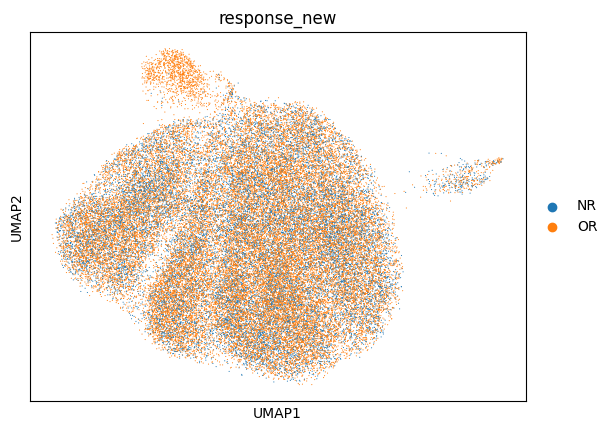

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='response_new')

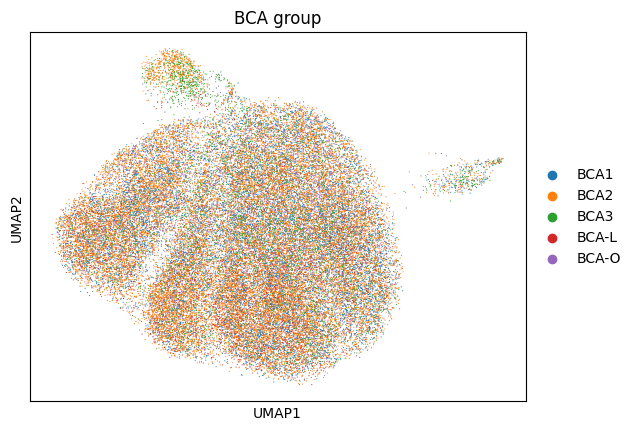

In [ ]:
sc.pl.umap(adata, color='BCA group')

In [ ]:
adata_latent.obs['response'].value_counts()

response
RL-    16200
CR     15000
RL+    14400
NR      3600
Name: count, dtype: int64

## Response split based on BCA labels

In [4]:
%reload_ext autoreload
from training import k_fold_cross_validation
cv_results = k_fold_cross_validation(
    adata_latent,
    input_dim=64,
    num_classes=2,
    hidden_dim=128,
    num_epochs=60,
    learning_rate=5e-4,
    weight_decay=1e-2,
    response_col='response_new',
    n_folds=3,  # Use 3 folds for extreme imbalance
    use_focal_loss=True,  # Enable Focal Loss
    alpha=0.75,  # 75% weight on minority class
    gamma=2.0,  # Focusing parameter
    save_path='B_ALL_results/kfold_focal_BCA_label'
)

Using device: cpu
using label col response_new
Original distribution: OR=48, NR=34

Fold 1/3
Train: OR=32, NR=22
Test: OR=16, NR=12
Using Focal Loss with alpha=[0.5925925925925926, 0.4074074074074074], gamma=2.0
Epoch 10: Loss=0.0835, Acc=0.5370
Epoch 20: Loss=0.0795, Acc=0.6481
Epoch 30: Loss=0.0668, Acc=0.6667
Epoch 40: Loss=0.0588, Acc=0.7222
Epoch 50: Loss=0.0467, Acc=0.8519
Epoch 60: Loss=0.0409, Acc=0.8704

Fold 1 Results:
Accuracy: 0.7143, Precision: 0.7222, Recall: 0.8125, F1: 0.7647

Fold 2/3
Train: OR=32, NR=23
Test: OR=16, NR=11
Using Focal Loss with alpha=[0.5818181818181818, 0.41818181818181815], gamma=2.0
Epoch 10: Loss=0.0838, Acc=0.5091
Epoch 20: Loss=0.0754, Acc=0.7273
Epoch 30: Loss=0.0678, Acc=0.7273
Epoch 40: Loss=0.0470, Acc=0.8727
Epoch 50: Loss=0.0431, Acc=0.8364
Epoch 60: Loss=0.0352, Acc=0.9091

Fold 2 Results:
Accuracy: 0.5926, Precision: 0.6190, Recall: 0.8125, F1: 0.7027

Fold 3/3
Train: OR=32, NR=23
Test: OR=16, NR=11
Using Focal Loss with alpha=[0.58181818